# 0. Import

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models import ResNet50_Weights
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, f1_score, recall_score,
    precision_score, roc_auc_score, average_precision_score, accuracy_score
)

from google.colab import drive
import warnings
import time
import random
from tqdm import tqdm

from torch.cuda.amp import GradScaler, autocast

warnings.filterwarnings("ignore")

In [29]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(device)

cuda


# 1. Data & Model loading

In [31]:
BASE_DIR = Path("/content/drive/My Drive/졸업 프로젝트/")
MULTIMODAL_MODEL_PATH = BASE_DIR / "multimodal_classifier_UML.pth"

# Clinical Data
DL_TEST_NPZ = BASE_DIR / 'dl_test_data.npz'

# US image data
TEST_IMG_NPZ = BASE_DIR / "validation_data.npz"

# 2. Data Preprocessing

In [32]:
BINARY_MAPPING = {
    0: 0, # Chocolate cyst (Benign)
    1: 0, # Serous cystadenoma (Benign)
    2: 0, # Teratoma (Benign)
    3: 0, # Theca cell tumor (Benign)
    4: 0, # Simple cyst (Benign)
    5: 0, # Normal ovary (Benign)
    6: 0, # Mucinous cystadenoma (Benign/Borderline)
    7: 1  # High grade serous cystadenocarcinoma (Malignant)
}

In [33]:
class MMOTUUnpairedDataset(Dataset):
    """
    초음파 이미지 데이터(.npz)와 임상 데이터(.npz)를 독립적으로 loading하고,
    Co-training을 위한 random sampling 수행
    """
    def __init__(self, img_npz_path, X_clin_np, Y_clin_np, device='cpu'):
        img_data = np.load(img_npz_path, allow_pickle=True)
        self.img_images = torch.from_numpy(img_data['images']).float()
        self.img_labels = torch.from_numpy(img_data['labels'].astype(np.float32)).float()

        self.clin_data = torch.from_numpy(X_clin_np).float()
        self.clin_labels = torch.from_numpy(Y_clin_np).float()

        self.img_len = len(self.img_images)
        self.clin_len = len(self.clin_data)
        self.max_len = max(self.img_len, self.clin_len)
        print(f"Dataset Initialized. Image Samples: {self.img_len}, Clinical Samples: {self.clin_len}")

    def __len__(self):
        return self.max_len

    def __getitem__(self, idx):
        img_idx = idx % self.img_len
        clin_idx = random.randint(0, self.clin_len - 1)

        return (
            self.img_images[img_idx],
            self.clin_data[clin_idx],
            self.img_labels[img_idx],
            self.clin_labels[clin_idx]
        )

# 3. Encoders

In [34]:
class ImageEncoder(nn.Module):
    def __init__(self, model_path, device):
        super().__init__()
        resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        self.backbone = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool,
            resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4,
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.output_dim = resnet.fc.in_features  # 2048

        try:
            state_dict = torch.load(model_path, map_location='cpu')
            model_dict = self.backbone.state_dict()
            pretrained_dict = {k: v for k, v in state_dict.items() if k in model_dict}
            model_dict.update(pretrained_dict)
            self.backbone.load_state_dict(model_dict, strict=False)
            print(f"Image Encoder loaded successfully from {model_path.name}")
        except Exception as e:
            print(f"[WARN]: Failed to load pretrained Image Encoder. Training from scratch. Error: {e}")

        # fine tuning : layer 3, 4만 학습 가능하도록 설정
        for name, param in self.backbone.named_parameters():
             if 'layer4' in name or 'layer3' in name:
                 param.requires_grad = True
             else:
                 param.requires_grad = False

    def forward(self, x):
        return torch.flatten(self.backbone(x), 1)

In [35]:
class ClinicalEncoder(nn.Module):
    def __init__(self, clinical_dim, shared_dim=512, dropout_rate=0.5):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(clinical_dim, 1024),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, shared_dim) # Shared Backbone 입력 차원
        )
        self.output_dim = shared_dim

    def forward(self, x):
        return self.encoder(x)

In [36]:
class MultiModalClassifier_UML(nn.Module):
    def __init__(self, img_encoder, clinical_dim, shared_dim=512, dropout_rate=0.5):
        super().__init__()

        # Image Encoder
        self.image_encoder = img_encoder
        self.img_proj = nn.Linear(self.image_encoder.output_dim, shared_dim)

        # Clinical Encoder
        self.clinical_encoder = ClinicalEncoder(clinical_dim, shared_dim, dropout_rate)

        # 1. Shared Backbone
        self.shared_backbone = nn.Sequential(
            nn.Linear(shared_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.shared_output_dim = 128

        # 2. Shared Classifier
        self.shared_classifier = nn.Sequential(
            nn.Linear(self.shared_output_dim, 1) # Binary Classification
        )

    def forward_single_modality(self, x_modality, modality_type):
        """단일 모달리티의 입력을 받아 Shared Backbone을 통과 후 Logit 반환"""

        if modality_type == 'image':
            feat = self.image_encoder(x_modality)
            feat_proj = self.img_proj(feat)
        elif modality_type == 'clinical':
            feat_proj = self.clinical_encoder(x_modality)
        else:
            raise ValueError("Invalid modality type")

        # Shared Backbone 통과 (Cross-modal transfer 발생)
        shared_feat = self.shared_backbone(feat_proj)

        # Shared Classifier 통과
        logits = self.shared_classifier(shared_feat)
        return logits, shared_feat

    def forward(self, x_img, x_clin):
        logits_img, _ = self.forward_single_modality(x_img, 'image')
        logits_clin, _ = self.forward_single_modality(x_clin, 'clinical')

        return logits_img, logits_clin

# 4. Evaluation

In [37]:
def plot_metrics(metrics: dict, threshold: float):
    """ 성능 지표를 막대 그래프로 시각화 """

    # 그래프에 포함할 주요 지표 선택
    plot_keys = ["F1 Score", "ROC-AUC", "PR-AUC", "Recall (Sensitivity)", "Precision", "Specificity (TNR)", "Acc"]
    plot_values = [metrics[k] for k in plot_keys]

    plt.figure(figsize=(12, 6))
    sns.set_theme(style="whitegrid")

    # 막대 그래프 생성
    bars = plt.bar(plot_keys, plot_values, color=['teal', 'darkorange', 'gold', 'firebrick', 'cornflowerblue', 'darkgreen', 'gray'], alpha=0.8)

    # 각 막대 위에 값 표시
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom', fontsize=10)

    plt.ylim(0, 1.05)
    plt.ylabel("Score", fontsize=12)
    plt.title(f"UML Model Image Modality Performance (Threshold: {threshold})", fontsize=14)
    plt.xticks(rotation=15, ha='right')
    plt.tight_layout()
    plt.show()

In [38]:
def calculate_metrics(y_true, y_pred, y_prob, threshold):
    """ 예측 결과(y_pred, y_prob)를 기반으로 모든 요구 지표를 계산 """

    y_pred_thresh = (y_prob >= threshold).astype(int)

    # Confusion Matrix 계산
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_thresh, labels=[0, 1]).ravel()

    # 1. Accuracy
    accuracy = accuracy_score(y_true, y_pred_thresh)
    # 2. Recall (Sensitivity)
    recall = recall_score(y_true, y_pred_thresh, zero_division=0)
    # 3. Precision
    precision = precision_score(y_true, y_pred_thresh, zero_division=0)
    # 4. F1-score
    f1 = f1_score(y_true, y_pred_thresh, zero_division=0)
    # 5. ROC-AUC
    try:
        auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        auc = np.nan
    # 6. PR-AUC (Average Precision Score)
    pr_auc = average_precision_score(y_true, y_prob)
    # 7. Specificity (TNR)
    # TNR = TN / (TN + FP)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    return {
        "Acc": accuracy,
        "Recall (Sensitivity)": recall,
        "Precision": precision,
        "F1 Score": f1,
        "ROC-AUC": auc,
        "PR-AUC": pr_auc,
        "Specificity (TNR)": specificity,
        "Confusion Matrix": (tn, fp, fn, tp)
    }

@torch.no_grad()
def evaluate_model_full(model, loader, device, threshold=0.5):
    model.eval()
    y_true, y_prob = [], []

    for x_img, x_clin, y_img, y_clin in loader:
        x_img = x_img.to(device)

        # 평가 시에는 이미지 모달리티만 사용하여 예측
        logits, _ = model.forward_single_modality(x_img, 'image')
        probs = torch.sigmoid(logits)

        y_true.extend(y_img.cpu().numpy().ravel())
        y_prob.extend(probs.cpu().numpy().ravel())

    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    y_pred = (y_prob >= threshold).astype(int) # 예측 결과 (임계값 적용)

    metrics = calculate_metrics(y_true, y_pred, y_prob, threshold)

    print(f"\n--- Evaluation at Threshold {threshold} ---")
    print(f"Accuracy: {metrics['Acc']:.4f} | F1 Score: {metrics['F1 Score']:.4f} | ROC-AUC: {metrics['ROC-AUC']:.4f}")
    print(f"Recall: {metrics['Recall (Sensitivity)']:.4f} | Precision: {metrics['Precision']:.4f} | Specificity (TNR): {metrics['Specificity (TNR)']:.4f}")
    print(f"PR-AUC: {metrics['PR-AUC']:.4f}")
    print("\nConfusion Matrix (TN, FP, FN, TP):", metrics['Confusion Matrix'])
    # Classification Report 출력 (세부 정보)
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=['Benign (0)', 'Malignant (1)'], digits=4, zero_division=0))
    plot_metrics(metrics, threshold)

# 5. Main execution

In [39]:
print("Loading pre-processed data from NPZ files...")

# Clinical DL Data
try:
    clin_test_data = np.load(DL_TEST_NPZ)

    X_clin_test = clin_test_data['X_test']
    Y_clin_test = clin_test_data['Y_test']

    CLINICAL_DATA_DIM = X_clin_test.shape[1]
    print(f"Clinical DL data loaded. Feature Dim: {CLINICAL_DATA_DIM}")

except FileNotFoundError:
    print(f"[ERROR] Clinical NPZ files not found.")
    exit()

# Image Data
test_dataset = MMOTUUnpairedDataset(TEST_IMG_NPZ, X_clin_test, Y_clin_test, device=device)

BATCH_SIZE = 64
NUM_WORKERS = 4

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

Loading pre-processed data from NPZ files...
Clinical DL data loaded. Feature Dim: 37
Dataset Initialized. Image Samples: 469, Clinical Samples: 40020


In [40]:
image_encoder = ImageEncoder(model_path=None, device='cpu').to(device)

multi_model = MultiModalClassifier_UML(
    img_encoder=image_encoder,
    clinical_dim=CLINICAL_DATA_DIM
).to(device)

[WARN]: Failed to load pretrained Image Encoder. Training from scratch. Error: 'NoneType' object has no attribute 'seek'. You can only torch.load from a file that is seekable. Please pre-load the data into a buffer like io.BytesIO and try to load from it instead.


Multimodal model loaded successfully from multimodal_classifier_UML.pth

=== FINAL MULTIMODAL EVALUATION ===

--- Evaluation at Threshold 0.5 ---
Accuracy: 0.9595 | F1 Score: 0.3881 | ROC-AUC: 0.7449
Recall: 0.4009 | Precision: 0.3760 | Specificity (TNR): 0.9780
PR-AUC: 0.2216

Confusion Matrix (TN, FP, FN, TP): (np.int64(37885), np.int64(853), np.int64(768), np.int64(514))

Classification report:
               precision    recall  f1-score   support

   Benign (0)     0.9801    0.9780    0.9791     38738
Malignant (1)     0.3760    0.4009    0.3881      1282

     accuracy                         0.9595     40020
    macro avg     0.6781    0.6895    0.6836     40020
 weighted avg     0.9608    0.9595    0.9601     40020



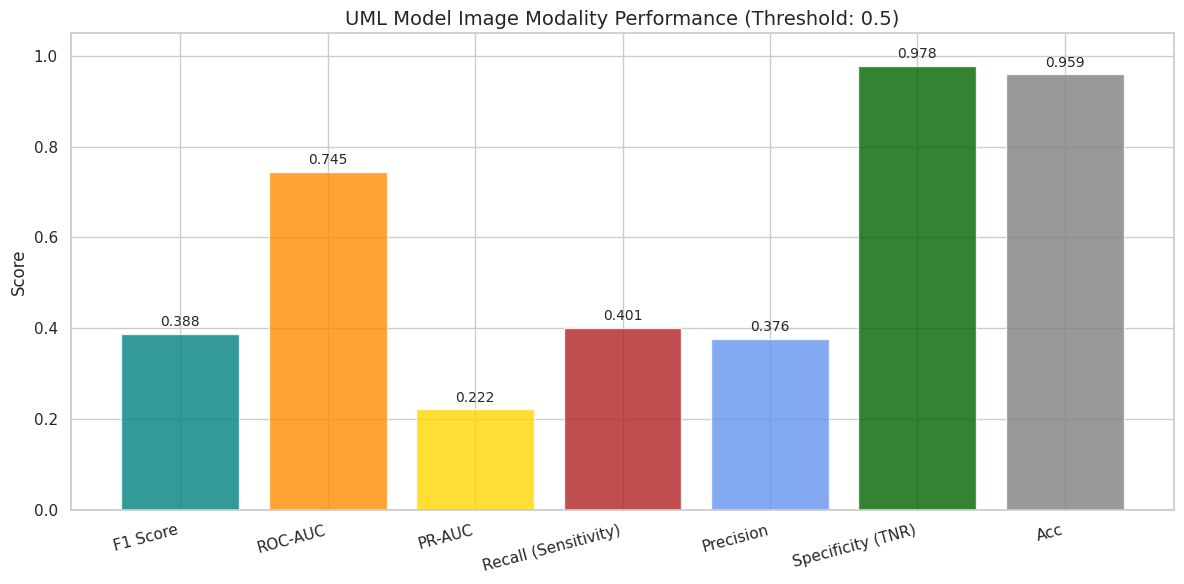


--- Evaluation at Threshold 0.4 ---
Accuracy: 0.9509 | F1 Score: 0.3437 | ROC-AUC: 0.7449
Recall: 0.4009 | Precision: 0.3008 | Specificity (TNR): 0.9692
PR-AUC: 0.2216

Confusion Matrix (TN, FP, FN, TP): (np.int64(37543), np.int64(1195), np.int64(768), np.int64(514))

Classification report:
               precision    recall  f1-score   support

   Benign (0)     0.9800    0.9692    0.9745     38738
Malignant (1)     0.3008    0.4009    0.3437      1282

     accuracy                         0.9509     40020
    macro avg     0.6404    0.6850    0.6591     40020
 weighted avg     0.9582    0.9509    0.9543     40020



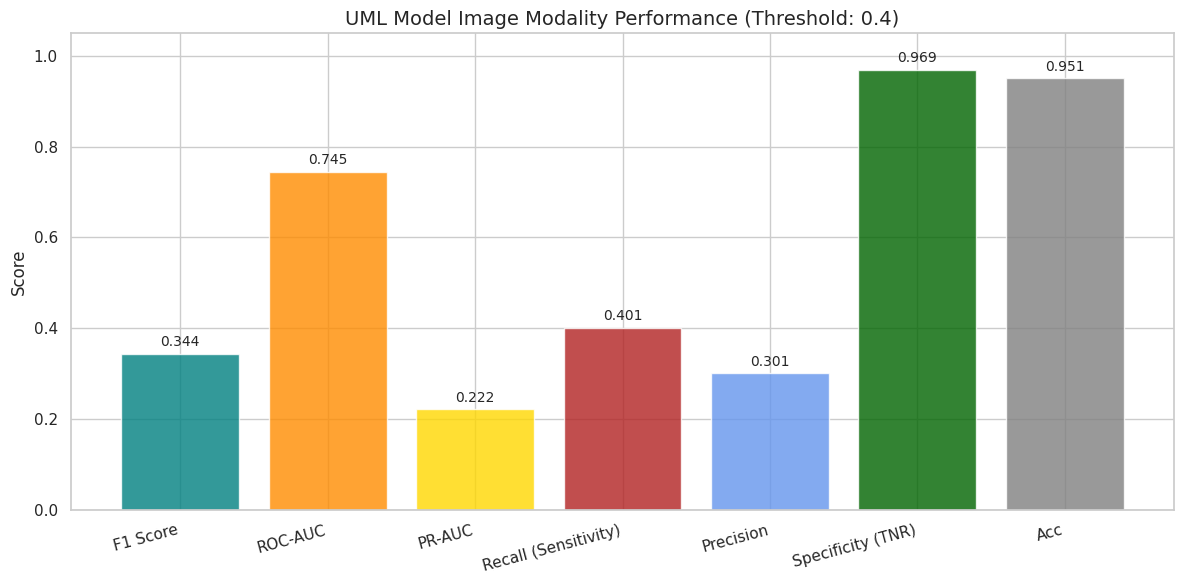


--- Evaluation at Threshold 0.3 ---
Accuracy: 0.9488 | F1 Score: 0.3341 | ROC-AUC: 0.7449
Recall: 0.4009 | Precision: 0.2864 | Specificity (TNR): 0.9669
PR-AUC: 0.2216

Confusion Matrix (TN, FP, FN, TP): (np.int64(37457), np.int64(1281), np.int64(768), np.int64(514))

Classification report:
               precision    recall  f1-score   support

   Benign (0)     0.9799    0.9669    0.9734     38738
Malignant (1)     0.2864    0.4009    0.3341      1282

     accuracy                         0.9488     40020
    macro avg     0.6331    0.6839    0.6537     40020
 weighted avg     0.9577    0.9488    0.9529     40020



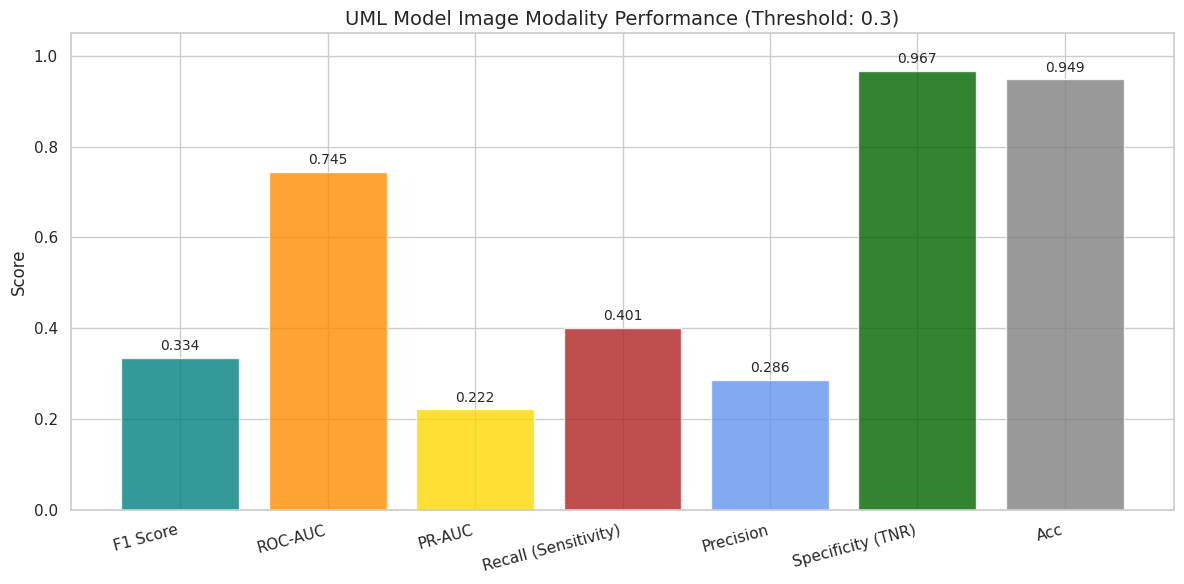


--- Evaluation at Threshold 0.2 ---
Accuracy: 0.9424 | F1 Score: 0.3084 | ROC-AUC: 0.7449
Recall: 0.4009 | Precision: 0.2506 | Specificity (TNR): 0.9603
PR-AUC: 0.2216

Confusion Matrix (TN, FP, FN, TP): (np.int64(37201), np.int64(1537), np.int64(768), np.int64(514))

Classification report:
               precision    recall  f1-score   support

   Benign (0)     0.9798    0.9603    0.9700     38738
Malignant (1)     0.2506    0.4009    0.3084      1282

     accuracy                         0.9424     40020
    macro avg     0.6152    0.6806    0.6392     40020
 weighted avg     0.9564    0.9424    0.9488     40020



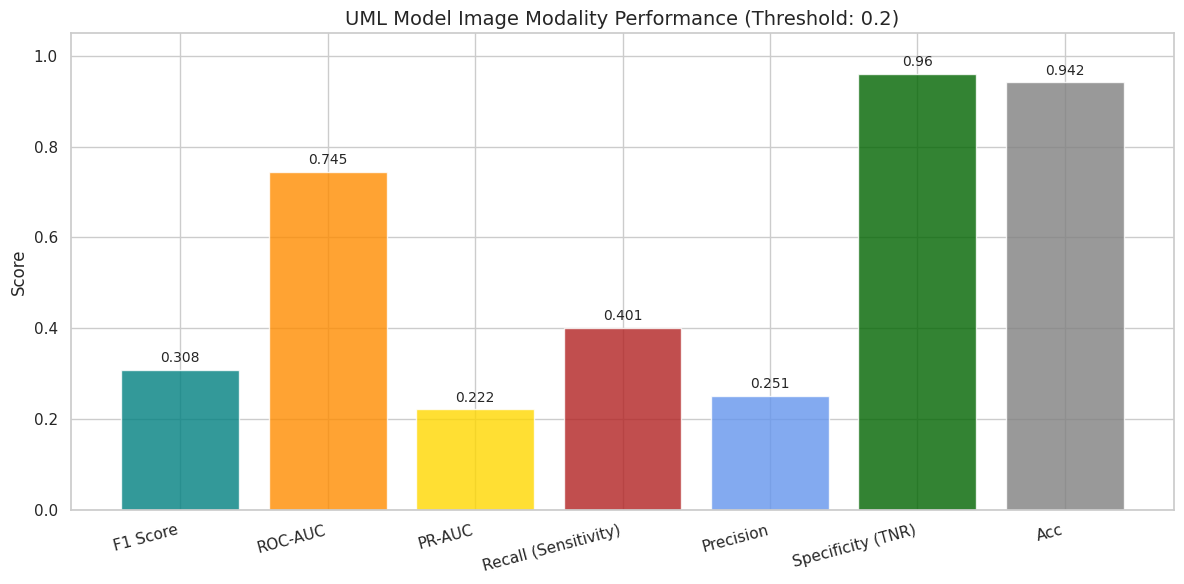


--- Evaluation at Threshold 0.1 ---
Accuracy: 0.9275 | F1 Score: 0.2615 | ROC-AUC: 0.7449
Recall: 0.4009 | Precision: 0.1940 | Specificity (TNR): 0.9449
PR-AUC: 0.2216

Confusion Matrix (TN, FP, FN, TP): (np.int64(36603), np.int64(2135), np.int64(768), np.int64(514))

Classification report:
               precision    recall  f1-score   support

   Benign (0)     0.9794    0.9449    0.9619     38738
Malignant (1)     0.1940    0.4009    0.2615      1282

     accuracy                         0.9275     40020
    macro avg     0.5867    0.6729    0.6117     40020
 weighted avg     0.9543    0.9275    0.9394     40020



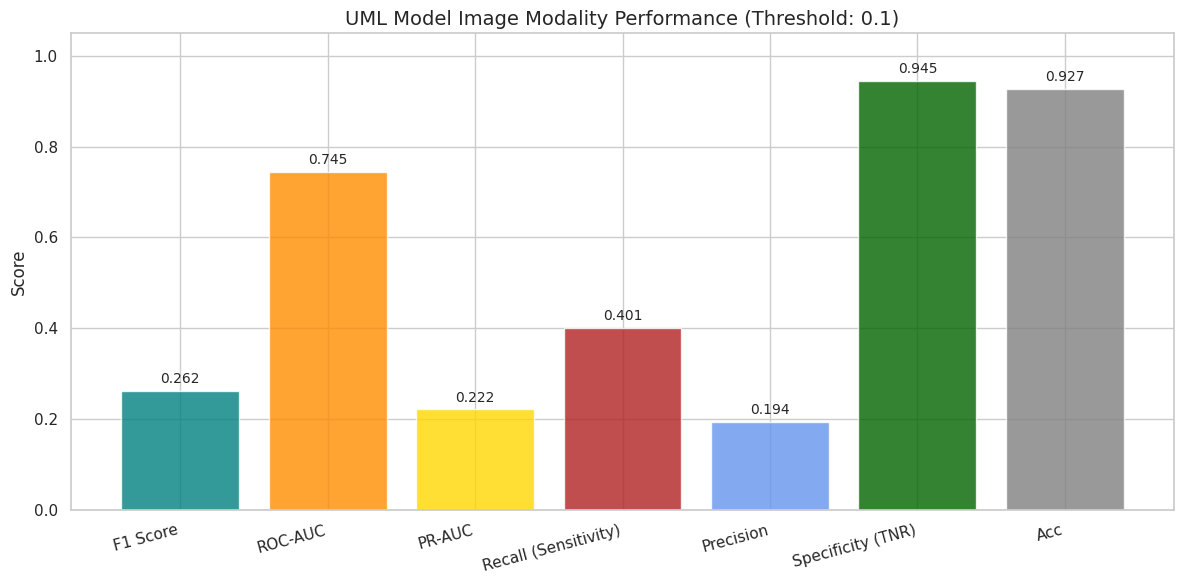

In [41]:
try:
    state_dict = torch.load(MULTIMODAL_MODEL_PATH, map_location=device)
    multi_model.load_state_dict(state_dict)
    print(f"Multimodal model loaded successfully from {MULTIMODAL_MODEL_PATH.name}")
except FileNotFoundError:
    print(f"[ERROR] Multimodal model file not found at {MULTIMODAL_MODEL_PATH}")
    exit()
except RuntimeError as e:
    print(f"[ERROR] State dict mismatch during loading. Ensure model path is correct. Error: {e}")
    exit()

print("\n=== FINAL MULTIMODAL EVALUATION ===")
evaluate_model_full(multi_model, test_loader, device, threshold=0.5)
evaluate_model_full(multi_model, test_loader, device, threshold=0.4)
evaluate_model_full(multi_model, test_loader, device, threshold=0.3)
evaluate_model_full(multi_model, test_loader, device, threshold=0.2)
evaluate_model_full(multi_model, test_loader, device, threshold=0.1)